In [9]:
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo 
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [73]:
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# load data into df
X = abalone.data.features 
y = abalone.data.targets 

#dont use sex feature
X_sexless = X.drop(columns=['Sex'])

#class rings from target
average_y = y['Rings'].mean()
classRings = y['Rings'].apply(lambda x: 1 if x >= average_y else 0)

# split data
X_train,X_test,y_train,y_test=train_test_split(X_sexless,classRings, test_size=0.33, random_state=42)

In [74]:
# use a gaussian for each variable
report_table = pd.DataFrame(columns=['variable', 'mean', 'var', 'accuracy','precision','recall'])

for variable in X_train.columns:
    gnb = GaussianNB()
    y_pred = gnb.fit(X_train[[variable]].values, y_train).predict(X_test[[variable]].values)
    # print(gnb.theta_)
    # print(gnb.var_)
    accuracy = (y_test == y_pred).sum()/X_test.shape[0]
    precision = (y_test == y_pred).sum() / y_pred.sum()
    recall = (y_test == y_pred).sum() / y_test.sum()
    report_table = pd.concat([report_table, pd.DataFrame({'variable': variable, 'mean':gnb.theta_[0], 'var': gnb.var_[0], 'accuracy': accuracy, 'precision': precision, 'recall': recall}, index=[0])], ignore_index=True)

report_table

,variable,mean,var,accuracy,precision,recall
0,Length,0.463943,0.013969,0.708484,1.187120,1.460389
1,Diameter,0.356865,0.009369,0.726613,1.237037,1.497758
2,Height,0.119095,0.001950,0.744017,1.269802,1.533632
3,Whole_weight,0.574403,0.146426,0.727339,1.641571,1.499253
4,Shucked_weight,0.262761,0.034090,0.674402,1.620209,1.390135
5,Viscera_weight,0.125555,0.007523,0.708484,1.687392,1.460389
6,Shell_weight,0.160143,0.010163,0.759971,1.706840,1.566517


In [75]:
def root(mu0,mu1,var0,var1):
    a = var0-var1
    b = 2*(mu0*var1 - mu1*var0)
    c = var0*mu1**2 - var1*mu0**2 - 2*(var0*var1)*np.log(np.sqrt(var0/var1))
    return np.roots([a,b,c])


decision boundary: 0.24982986416951422


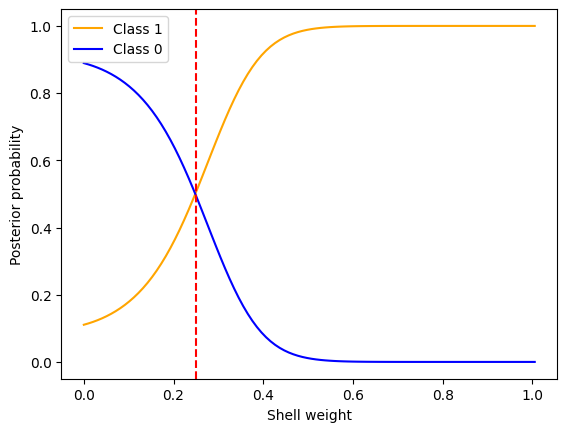

In [80]:
# Shell weight classifier is the best ( all metrics are the highest )
gnbBest = GaussianNB()
y_pred = gnbBest.fit(X_train[['Shell_weight']].values, y_train)
x_plot = np.linspace(0,X_sexless.Shell_weight.max(),100)
probabilities = gnbBest.predict_proba(x_plot.reshape(-1, 1))

# convert theta and var to rank-1 arrays
theta = gnbBest.theta_.flatten()
var = gnbBest.var_.flatten()

a,b=  root(theta[0], theta[1], var[0], var[1])
print('decision boundary:',b)
plt.plot(x_plot,probabilities[:, 1], color='orange',label='Class 1');
plt.plot(x_plot,probabilities[:, 0], color='blue',label='Class 0');
plt.xlabel('Shell weight')
plt.axvline(x=b, color='red', linestyle='--');
plt.ylabel('Posterior probability')
plt.legend();


In [77]:

def sigma_mle(vec):
    pos =  vec[0]/2+np.sqrt(vec[0]/4+4*(vec[1]**2-vec[1]*vec[0]))/2*(1-vec[1]/vec[0])
    neg =  vec[0]/2-np.sqrt(vec[0]/4+4*(vec[1]**2-vec[1]*vec[0]))/2*(1-vec[1]/vec[0]) 
    if pos>0:
        return pos
    elif neg>0:
        return neg
    else:
        return 0
class CustomGaussianNB(GaussianNB):
    def _partial_fit(self, X, y, classes=None, _refit=False,sample_weight=None):
        # Call the parent class's _partial_fit function
        super()._partial_fit(X, y,classes)
        variance_matrix = self.var_
        variances_vector =variance_matrix.sum(axis=1)
        sigma = sigma_mle(variances_vector)
        unique_variance = np.array([1,1])*sigma
        self.var_ = np.array([unique_variance,unique_variance])
        self.var_[:, :] += self.epsilon_

        # Update if only no priors is provided
        if self.priors is None:
            # Empirical prior, with sample_weight taken into account
            self.class_prior_ = self.class_count_ / self.class_count_.sum()

        return self


In [78]:
import itertools

gnbCustom = CustomGaussianNB()
# Get the column names of X
column_names = X_train.columns

# Create all possible pairs of features
feature_pairs = list(itertools.combinations(column_names, 2))
report_table = pd.DataFrame(columns=['variable0','variable1', 'mean', 'sigma', 'accuracy','precision','recall'])

# Print the feature pairs
for pair in feature_pairs:
    gnbCustom = CustomGaussianNB()
    y_pred = gnb.fit(X_train[list(pair)].values, y_train).predict(X_test[list(pair)].values)
    # print(gnb.theta_)
    # print(gnb.var_)
    accuracy = (y_test == y_pred).sum()/X_test.shape[0]
    precision = (y_test == y_pred).sum() / y_pred.sum()
    recall = (y_test == y_pred).sum() / y_test.sum()
    report_table = pd.concat([report_table, pd.DataFrame({'variable0': pair[0],'variable1':pair[1], 'mean':str(gnb.theta_[0]), 'sigma':str(gnb.var_[0][0]), 'accuracy': accuracy, 'precision': precision, 'recall': recall}, index=[0])], ignore_index=True)

report_table

,variable0,variable1,mean,sigma,accuracy,precision,recall
0,Length,Diameter,[0.463943 0.35686508],0.01396910282609133,0.720812,1.233251,1.485800
1,Length,Height,[0.463943 0.11909452],0.01396910282609133,0.728064,1.242574,1.500747
2,Length,Whole_weight,[0.463943 0.57440332],0.013969103054905408,0.725888,1.407876,1.496263
3,Length,Shucked_weight,[0.463943 0.26276118],0.013969102862013768,0.712110,1.383099,1.467862
4,Length,Viscera_weight,[0.463943 0.12555519],0.01396910282609133,0.712110,1.383099,1.467862
5,Length,Shell_weight,[0.463943 0.16014322],0.01396910283159847,0.736041,1.431594,1.517190
6,Diameter,Height,[0.35686508 0.11909452],0.009369122498862324,0.741842,1.277154,1.529148
7,Diameter,Whole_weight,[0.35686508 0.57440332],0.0093691227321979,0.729514,1.393352,1.503737
8,Diameter,Shucked_weight,[0.35686508 0.26276118],0.00936912253930626,0.715736,1.388186,1.475336
9,Diameter,Viscera_weight,[0.35686508 0.12555519],0.009369122501032561,0.724438,1.393305,1.493274


In [79]:
# best performing pair is (Shell weight,Height) with the highest accuracy and recall
display(report_table[report_table['accuracy'] == report_table['accuracy'].max()])
# display(report_table[report_table['recall'] == report_table['recall'].max()])
# report_table[report_table['precision'] == report_table['precision'].max()]    
   

,variable0,variable1,mean,sigma,accuracy,precision,recall
14,Height,Shell_weight,[0.11909452 0.16014322],0.0019495589075091467,0.761421,1.508621,1.569507


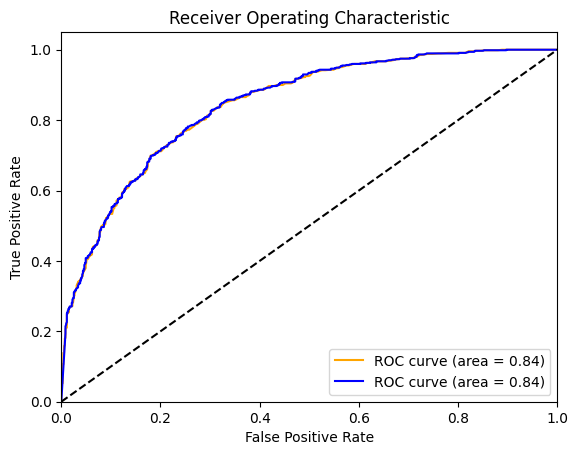

In [84]:
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for the positive class
y_pred_prob_uni = gnbBest.predict_proba(X_test[['Shell_weight']].values)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr_uni, tpr_uni, thresholds_uni = roc_curve(y_test, y_pred_prob_uni)

# Compute the area under the ROC curve
roc_auc_uni = auc(fpr_uni, tpr_uni)


# Fit the model on the training data
gnbBi = gnbCustom.fit(X_train[['Shell_weight','Height']].values, y_train)

# Get the predicted probabilities for the positive class
y_pred_prob_bi = gnbBi.predict_proba(X_test[['Shell_weight','Height']].values)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr_bi, tpr_bi, thresholds_bi = roc_curve(y_test, y_pred_prob_bi)

# Compute the area under the ROC curve
roc_auc = auc(fpr_bi, tpr_bi)

# Plot the ROC curve
plt.plot(fpr_uni, tpr_uni, label='ROC curve (area = %0.2f)' % roc_auc, color='orange')
plt.plot(fpr_bi, tpr_bi, label='ROC curve (area = %0.2f)' % roc_auc, color='blue')
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
